# Sentiment Analysis with Word2Vec, LSTM and Bayesian Optimization

In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

!pip install gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]  # Remove neutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipython-input-135965717.py:2: ParserWarning: Skipping line 545928: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


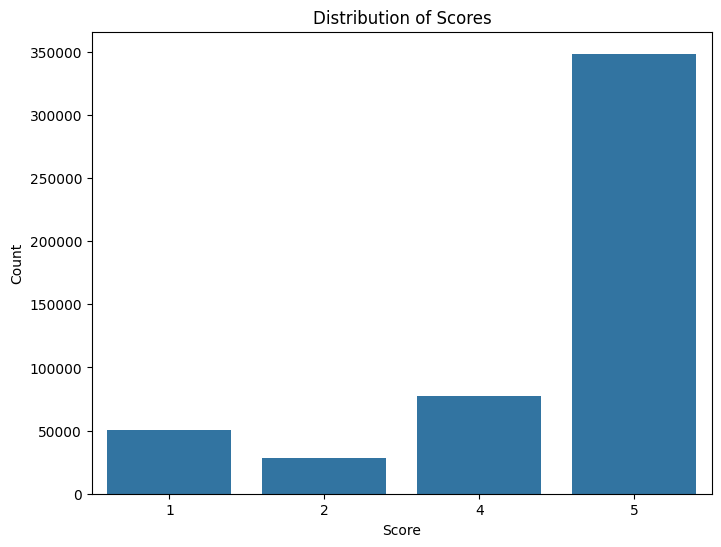

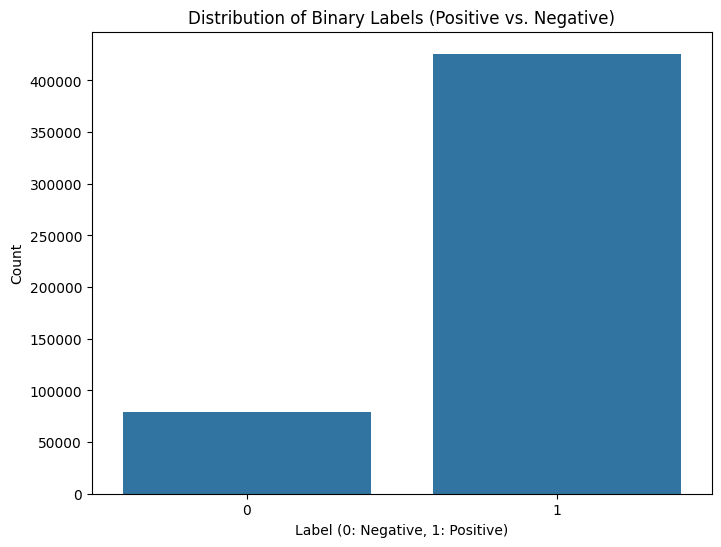

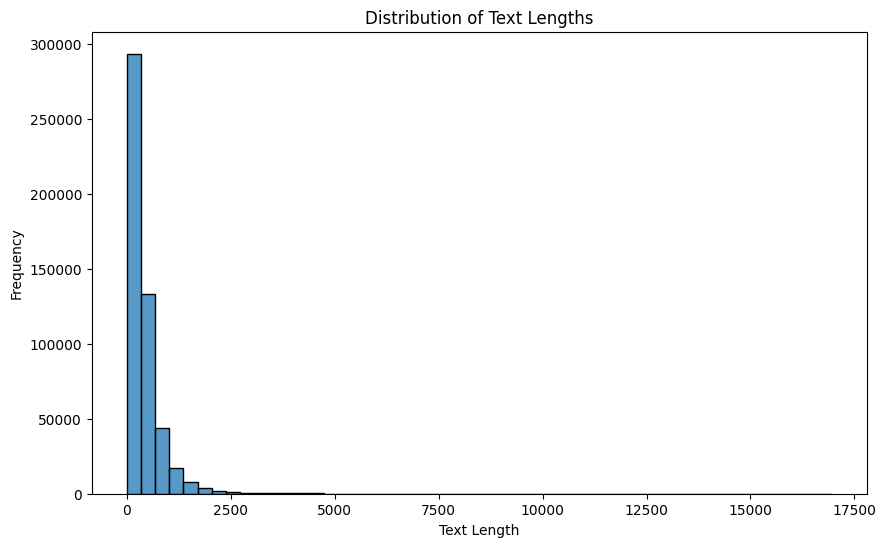

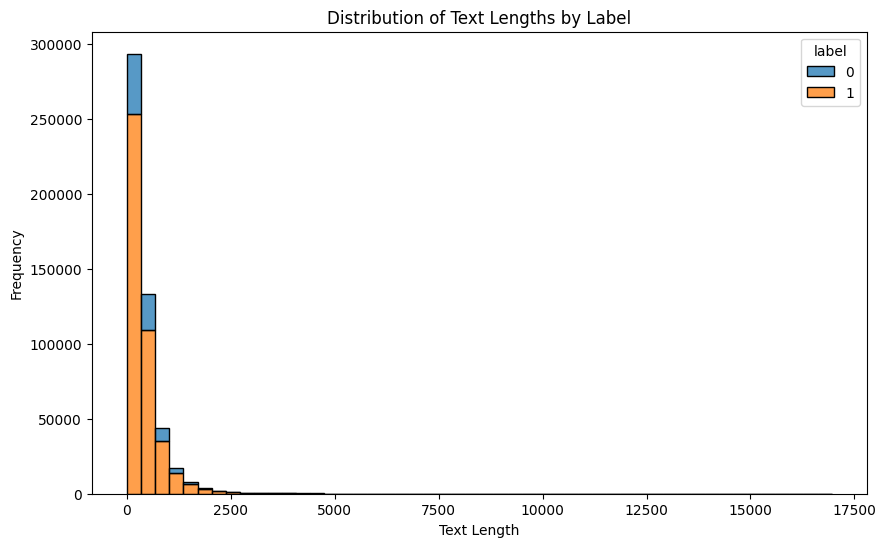

In [3]:
import matplotlib.pyplot as plt
# Check the distribution of scores
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check the distribution of the new binary label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Binary Labels (Positive vs. Negative)')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Distribution of review length
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of text length by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, multiple="stack")
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
# using 10000 review for model training and evaluation
df = df.sample(15000)

In [5]:
df.head()

,Text,Score,label,text_length
411934,"My grocery stopped carrying this item, I tried...",5,1,184
269209,My fussy cats love this food and from what I'v...,5,1,215
361067,I didn't expect to get so many treats!!! They'...,5,1,265
308101,My picky eater loves this! She will eat only G...,5,1,363
88261,I read Ceylon was the cinnamon used before it ...,5,1,304


In [6]:
df.shape

(15000, 4)

In [7]:
# Text Cleaning Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

In [8]:
df.cleaned_text.head(5)

,cleaned_text
411934,grocery stopped carrying item tried another br...
269209,fussy cat love food read good finally win also...
361067,expect get many treat small perfect training d...
308101,picky eater love eat gerber organic mac n chee...
88261,read ceylon cinnamon used became expensive u c...


In [9]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=200)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Build and train the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_train = time.time()
history = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.1, verbose=1)
end_train = time.time()

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 86s 957ms/step - accuracy: 0.8193 - loss: 0.4982 - val_accuracy: 0.8725 - val_loss: 0.2880
Epoch 2/2
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 961ms/step - accuracy: 0.9050 - loss: 0.2291 - val_accuracy: 0.9017 - val_loss: 0.2570


In [11]:
# Evaluate the model
start_test = time.time()
y_pred = (model.predict(X_test) > 0.5).astype("int32")
end_test = time.time()

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Training Time:", end_train - start_train)
print("Testing Time:", end_test - start_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
Accuracy: 0.8976666666666666
Training Time: 168.220472574234
Testing Time: 10.29760217666626


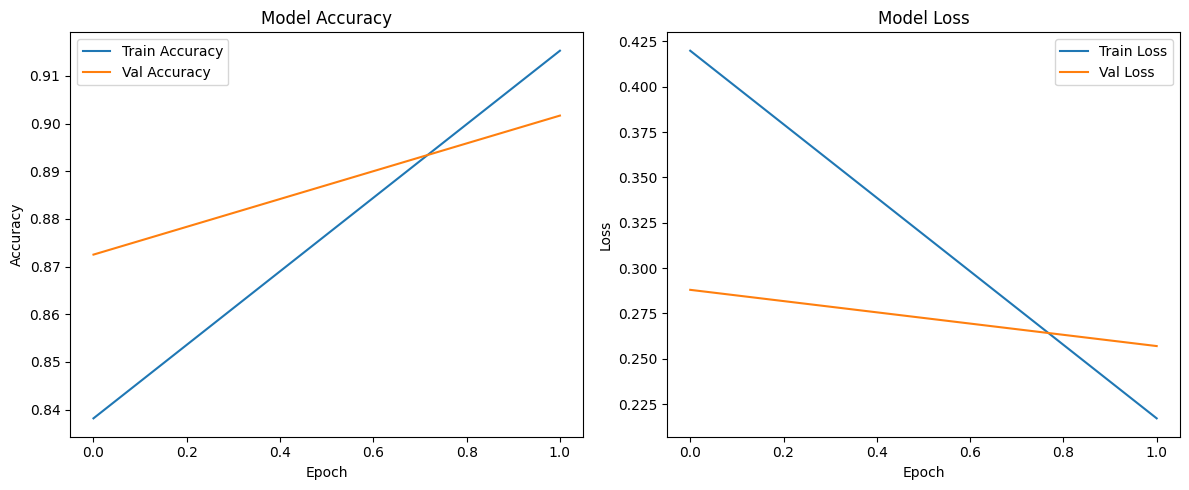

In [12]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

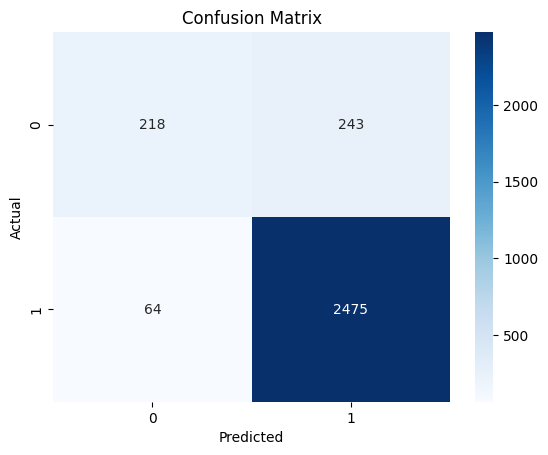

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()